In [71]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import RobustScaler  
%matplotlib inline

In [72]:
def import_raw_data(operating_system ='mac'):
    '''generate a dictionary of raw dataframes
    
    parameters
    -----------
    type of operating system used windows or mac
    default mac
    
    '''
    if operating_system == 'mac':
        base_file_path = r"/Users/{}/Desktop/data".format(os.getlogin())
    if operating_system == 'windows':
        base_file_path = r"C:\Users\{}\Desktop\data".format(os.getlogin())
    df_dict = dict()
    for file in os.listdir(base_file_path):
        if file.endswith('.csv'):
            df_dict[file.split('.')[0]] = pd.read_csv(os.path.join(base_file_path,file))
    return df_dict

# import data

In [73]:
df_dict = import_raw_data()
df_dict.keys()

dict_keys(['weather_country_month_v2', 'country_iso_data', 'temperature', 'winemag-data-130k-v2', 'winemag-data_first150k'])

In [74]:
df = df_dict.get('winemag-data-130k-v2').copy()
temp_df = df_dict.get('temperature').copy()
country_iso = df_dict.get('country_iso_data').copy()
weather_month_v2 = df_dict.get('weather_country_month_v2').copy()

In [75]:
# changed from using original quantile list, big factor in driving results
df['test'] = pd.cut(df['points'],bins=5,labels=[1,2,3,4,5])
df['test'].value_counts()

2    56270
3    48608
1    12430
4    12305
5      358
Name: test, dtype: int64

<AxesSubplot:xlabel='test', ylabel='count'>

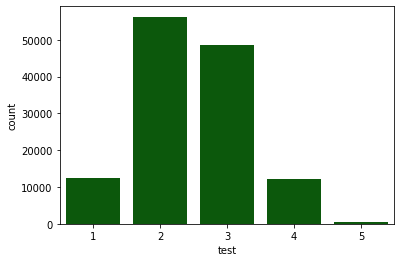

In [76]:
sns.countplot(x='test', color='darkgreen',
                  data=df)

In [77]:
df['test'].unique()

[2, 3, 1, 5, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

**columns to remove**

description, designation & Twitter handle removed at this stage, explore later

In [78]:
COLUMN_DROP = ['Unnamed: 0','designation','region_2','taster_twitter_handle','points']
df.drop(columns=COLUMN_DROP,inplace=True)

In [79]:
df.isnull().sum()

country           63
description        0
price           8996
province          63
region_1       21247
taster_name    26244
title              0
variety            1
winery             0
test               0
dtype: int64

## dealing with missing data


In [80]:
df.dropna(subset=['variety','province','country'],inplace=True)

In [81]:
print(df.shape)
df.isnull().sum()

(129907, 10)


country            0
description        0
price           8992
province           0
region_1       21183
taster_name    26243
title              0
variety            0
winery             0
test               0
dtype: int64

In [82]:
df[df['taster_name'].isnull()].head()

,country,description,price,province,region_1,taster_name,title,variety,winery,test
31,Italy,Merlot and Nero d'Avola form the base for this...,NaN,Sicily & Sardinia,Sicilia,NaN,Duca di Salaparuta 2010 Calanìca Nero d'Avola-...,Red Blend,Duca di Salaparuta,2
32,Italy,"Part of the extended Calanìca series, this Gri...",NaN,Sicily & Sardinia,Sicilia,NaN,Duca di Salaparuta 2011 Calanìca Grillo-Viogni...,White Blend,Duca di Salaparuta,2
33,US,"Rustic and dry, this has flavors of berries, c...",50.0,California,Dry Creek Valley,NaN,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Red Blend,Envolve,2
34,US,"This shows a tart, green gooseberry flavor tha...",20.0,California,Sonoma Valley,NaN,Envolve 2011 Sauvignon Blanc (Sonoma Valley),Sauvignon Blanc,Envolve,2
37,Italy,This concentrated Cabernet offers aromas of cu...,21.0,Sicily & Sardinia,Sicilia,NaN,Feudi del Pisciotto 2010 Missoni Cabernet Sauv...,Cabernet Sauvignon,Feudi del Pisciotto,2


In [83]:
print(df.taster_name.unique())

['Kerin O’Keefe' 'Roger Voss' 'Paul Gregutt' 'Alexander Peartree'
 'Michael Schachner' 'Anna Lee C. Iijima' 'Virginie Boone' 'Matt Kettmann'
 nan 'Sean P. Sullivan' 'Jim Gordon' 'Joe Czerwinski'
 'Anne Krebiehl\xa0MW' 'Lauren Buzzeo' 'Mike DeSimone' 'Jeff Jenssen'
 'Susan Kostrzewa' 'Carrie Dykes' 'Fiona Adams' 'Christina Pickard']


In [84]:
df.dropna(subset=['taster_name'],inplace=True)

In [85]:
print(df.shape)

(103664, 10)


In [86]:
imp_median = SimpleImputer(strategy='median')
df['price'] = imp_median.fit_transform(df[['price']])
df.isnull().sum()

country            0
description        0
price              0
province           0
region_1       20817
taster_name        0
title              0
variety            0
winery             0
test               0
dtype: int64

In [87]:
df['region_1'] = df['region_1'].fillna("NONE")

In [88]:
#TODO : change to correct country name
# df['country'].replace({'US':'United States','England':})

# preprocessing  & Feature Engineering

extracting year from text and cleaing reuslt to produce valid year

In [89]:
## year 
count_year = df[df['title'].str.contains('\d',regex=True)].shape[0]
df['number_extract'] = df['title'].str.extract('(\d+)')
df['number_extract'] = np.where(len(df['number_extract'])<4 & len(df['number_extract'])<=5,np.nan,df['number_extract'])
df['number_extract'] = pd.to_numeric(df['number_extract'])

In [90]:
## 70 oldest wine found on internet 
df['number_extract'] = np.where(
                    (df['number_extract']>=2021) | (df['number_extract']<=(2021-70)),
                    np.nan,
                    df['number_extract'])

In [91]:
df['number_extract'].isnull().sum()

4267

adding simple imputer but may need to change

In [92]:
imp_median = SimpleImputer(strategy='median')
df['number_extract'] = imp_median.fit_transform(df[['number_extract']])
df['number_extract'] = pd.to_datetime(df['number_extract'],format='%Y').dt.year 
df.rename(columns={'number_extract':'year'},inplace=True)
df.isnull().sum()

country        0
description    0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
test           0
year           0
dtype: int64

In [93]:
df['year'].unique()

array([2013, 2011, 2012, 2010, 2007, 2009, 2008, 2014, 2015, 2016, 2006,
       2003, 2001, 2005, 2000, 1999, 2002, 2004, 2017, 1995, 1996, 1997,
       1998, 1992, 1994, 1976, 1964, 1983, 1967, 1988, 1980, 1987, 1993,
       1989, 1969, 1973, 1978, 1965, 1968, 1991, 1985, 1982, 1963, 1986,
       1957, 1966, 1984, 1961, 1990, 1952, 1974])

calculating length of the name to work out whether name longer names and titles relate to better reviews

In [94]:
for col in ['title','taster_name']:
     df[f"{col}_length"] = df[col].apply(lambda x: len(x))

3300.0


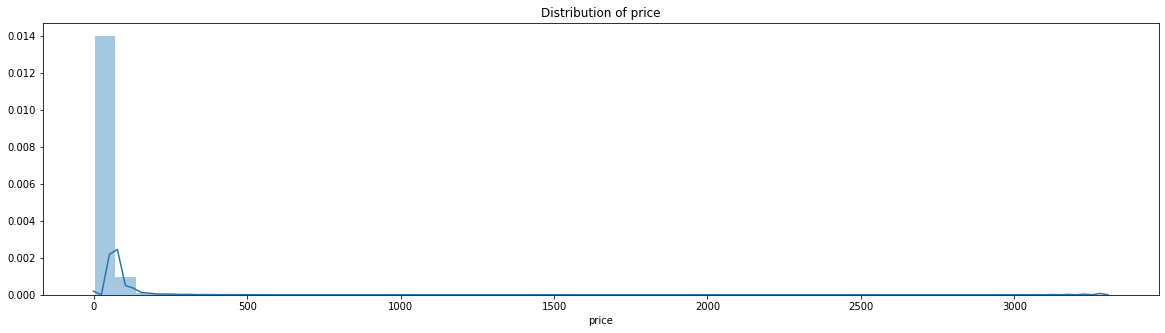

In [95]:
plt.figure(figsize=(20,5))
plt.title("Distribution of price")
ax = sns.distplot(df["price"])
print(df["price"].max())

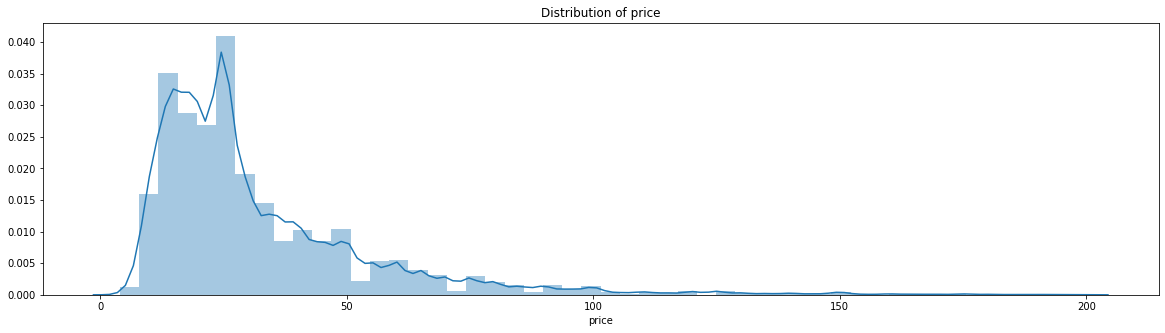

In [96]:
plt.figure(figsize=(20,5))
plt.title("Distribution of price")
ax = sns.distplot(df[df['price']<200]['price'])

In [97]:
#TODO change labels to numbers
df['price_bin'] = pd.cut(df['price'],bins=15,labels=False)

In [98]:
df['price_bin'].unique()

array([ 0,  1,  3,  2,  8,  4,  5, 11,  9, 14,  6])

In [99]:
df.drop(columns=['taster_name', 'title'],inplace=True)

# Add Weather Data

additional feature related to average temperature for each year

In [100]:
weather_feature = df.set_index('country').join(country_iso.set_index('country'))

In [101]:
weather_iso_df = weather_month_v2.set_index('country').join(country_iso.set_index('country'))
weather_iso_df['year'] = pd.to_datetime(weather_iso_df['month']).dt.year
weather_iso_summary_df = weather_iso_df.groupby(['country_iso', 'year'], as_index=False).mean()

In [102]:
df = pd.merge(
              weather_feature, 
              weather_iso_summary_df,  
              how='left', 
              left_on=['country_iso','year'], 
              right_on=['country_iso','year']
             )

In [103]:
imp_median = SimpleImputer(strategy='median')
df['avg_temp'] = imp_median.fit_transform(df[['avg_temp']])
df.isnull().sum()

description           0
price                 0
province              0
region_1              0
variety               0
winery                0
test                  0
year                  0
title_length          0
taster_name_length    0
price_bin             0
country_iso           0
avg_temp              0
dtype: int64

# NLP

In [104]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

In [105]:
# crap feature remove later
# def vocab_richness(text):
#     tokens = word_tokenize(text)
#     total_length = len(tokens)
#     unique_words = set(tokens)
#     unique_word_length = len(unique_words)
#     return unique_word_length/total_length

# df['vocab richness'] = df['description'].apply(vocab_richness)

## sentiment from text

In [106]:
# taken from kaggle
import string 
punc = set(string.punctuation)

#loading stop_words
nltk.download('stopwords')

# creating a set of stop words
stop_words = set(stopwords.words('english'))

# combining the 2 sets with an "or" operator (i.e. "|")
all_stops = stop_words | punc

# loop to pre-process data
clean_desc =[]
for item in df['description'].to_list():
    tok_desc = word_tokenize(item)
    lower_data = [i.lower() for i in tok_desc]
    tok_desc_no_num = [i for i in lower_data if i.isalpha()]
    filtered_desc = [i for i in tok_desc_no_num if i not in all_stops]
    clean_desc.append(filtered_desc)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edwardburroughes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
# Organizing the data in a new dataframe
clean_desc_untok = [' '.join(i) for i in clean_desc]
column_names = ['original_desc', 'untok_description']
data_tuple= list(zip(df['description'], clean_desc_untok))
desc_df = pd.DataFrame(data_tuple, columns=column_names)

In [108]:
nltk.download('movie_reviews')
tb = Blobber(analyzer=NaiveBayesAnalyzer())
blob = [tb(text) for text in desc_df['untok_description']]
sentiment_values = [text.sentiment for text in blob]

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/edwardburroughes/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [109]:
stats = pd.DataFrame(zip(*sentiment_values)).T
stats.columns = ['clf','pos','neg']
stats.head()

,clf,pos,neg
0,neg,0.0774711,0.922529
1,pos,0.835127,0.164873
2,pos,0.995154,0.00484628
3,neg,0.0718264,0.928174
4,pos,0.947882,0.0521175


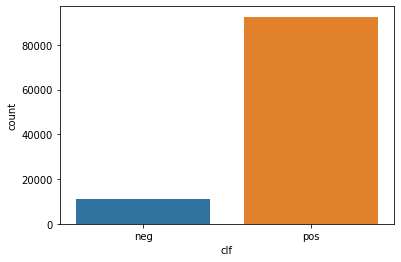

In [110]:
sns.countplot(stats['clf'])
df = df.join(stats)

move back onto original dataset

In [111]:
X = df.drop(columns=['test','description'])
y = df[['test']]

Holdout method on the data

In [112]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [113]:
X_train.columns

Index(['price', 'province', 'region_1', 'variety', 'winery', 'year',
       'title_length', 'taster_name_length', 'price_bin', 'country_iso',
       'avg_temp', 'clf', 'pos', 'neg'],
      dtype='object')

In [114]:
from sklearn import preprocessing 
def create_dummies(X,cat_columns):
    le = preprocessing.LabelEncoder()
    for col in cat_columns:
        X[col] = le.fit_transform(X[col])
    return X

#     remaining_cols = list(set(list(X.columns)) - set(cat_columns))
#     return pd.concat([X[remaining_cols],pd.get_dummies(X[cat_columns])],axis=1)

def scaling_data(X,numeric_features):
    RB = RobustScaler()
    remaining_cols = list(set(list(X.columns)) - set(numeric_features))
    return pd.concat([X[remaining_cols],RB.fit_transform(X[numeric_features])],axis=1)

In [115]:
# change scaler - for the model
numeric_features = ['price','title_length','taster_name_length','avg_temp','year','pos','neg']
RB = RobustScaler() 
X_train[numeric_features] = RB.fit_transform(X_train[numeric_features])
X_test[numeric_features] = RB.fit_transform(X_test[numeric_features])
import warnings 
warnings.simplefilter('ignore')

using F1-score as imbalanced dataset

In [116]:
from sklearn.metrics import f1_score
from sklearn import preprocessing

In [117]:
X_train = create_dummies(X_train,['province','variety','country_iso','price_bin','winery','region_1','clf'])
X_test = create_dummies(X_test,['province','variety','country_iso','price_bin','winery','region_1','clf'])

In [118]:
X_train.shape

(72564, 14)

In [119]:
X_test.shape

(31100, 14)

# Baseline Model

In [120]:
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [121]:
def f1(model,X_test,y_test):
    y_pred = model.predict(X_test)
    score = f1_score(y_test,y_pred,average='weighted')
    return score
f1(clf,X_test,y_test)

0.5115504121718074

bad score, we can definitely improve it

# Model Iterations

In [122]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_classifier.fit(X_train, y_train)
f1(rf_classifier,X_test,y_test)

0.5964482800095268

Using random forest is almost is definitely better still very low lets amend the imbalances in the data


as the data is imbalanced heavily weighted towards the ratings of 2.5 i.e.80-87, we'll use SMOTE to augment the dataset
generating artificial data. There are 3 different SMOTE methodologies commonly used, [link](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) has more details.

-SMOTE of the majority class in combination  random under sampling the minority class

-BorderlineSMOTE

-SVMSMOTE

Let's test them on the randomforest classifier :)

In [123]:
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SVMSMOTE
from sklearn import neighbors
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
smote_pipeline = Pipeline(steps=steps)

In [124]:
over = SMOTE(sampling_strategy='minority',k_neighbors=1)
X_train_resample,y_train_resample = over.fit_resample(X_train,y_train)
rf_classifier.fit(X_train_resample,y_train_resample)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [125]:
f1(rf_classifier,X_test,Y_test)

NameError: name 'Y_test' is not defined

In [ ]:
oversample = BorderlineSMOTE(sampling_strategy='minority',k_neighbors=1,m_neighbors=1)
X_train_resample,y_train_resample = over.fit_resample(X_train,y_train)
rf_classifier.fit(X_train_resample,y_train_resample)

In [ ]:
f1(rf_classifier,X_test,Y_test)

smote perhaps a more focused sampling strategy is required for balancing the data

In [ ]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([('o', oversample),
           ('rf', RandomForestClassifier())])
parameters = {'o__sampling_strategy':('minority','not majority','all'),
             'o__k_neighbors':[1,5],
             'o__m_neighbors':[1,20]}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=1, scoring = "f1_weighted", 
                           refit=True, cv=5)
grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

In [ ]:
from xgboost import XGBClassifier
xgb_classifier = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=7, n_estimators=200))
xgb_classifier.fit(X_train_resample, y_train_resample)

In [ ]:
f1(xgb_classifier,X_test,y_test)

# Feature Selection & Importance

In [ ]:
features = pd.DataFrame(zip(list(X_train.columns),list(rf_classifier.feature_importances_)))
features.columns = ['features','scores']

In [ ]:
features.sort_values(by='scores',ascending=False)

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_classifier, X_test, Y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{list(X.columns)[i]:<8}"
             f"{r.importances_mean[i]:.3f}"
             f" +/- {r.importances_std[i]:.3f}")

In [ ]:
#loop through the model assessing the best - using the cv_val_score -done
#grid search and randomsearch hyperparameter tuning
#then confusion matrix --> which ratings are driving the bad scores
#finalise parameters 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import datetime

model_map = {'knn':KNeighborsClassifier(),
            'rf':RandomForestClassifier,
            'svc':SVC,
            'nb':GaussianNB,
            'xgb':XGBClassifier,
            'ada':AdaBoostClassifier}

In [ ]:
knn = KNeighborsClassifier()
knn_score = cross_val_score(knn,X_train,y_train,cv=3,scoring='f1_weighted')
knn_score

In [ ]:
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_score = cross_val_score(rf,X_train,y_train,cv=3,scoring='f1_weighted')
rf_score

In [ ]:
nb = GaussianNB()
nb_score = cross_val_score(nb,X_train,y_train,cv=3,scoring='f1_weighted')
nb_score

In [ ]:
xgb = XGBClassifier()
xgb_score = cross_val_score(xgb,X_train,y_train,cv=3,scoring='f1_weighted')
xgb_score

In [ ]:
svc = SVC()
svc_score = cross_val_score(svc,X_train,y_train,cv=3,scoring='f1_weighted')
svc_score

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=500,n_jobs=-1),n_estimators=200,
                             algorithm = "SAMME.R", learning_rate = 0.5)
ada_clf_score = cross_val_score(ada_clf,X_train,y_train,cv=3,scoring='f1_weighted')

In [ ]:
list_scores = [knn_score,rf_score,svc_score,nb_score,xgb_score,ada_clf_score]
mean_score = [np.mean(i) for i in list_scores]
df_model_score = pd.DataFrame({'model_type':list(model_map.keys()),'mean_f1_score':mean_score})
df_model_score.sort_values('mean_f1_score',ascending=False,inplace=True)

In [ ]:
df_model_score

## Hyperparameter Tuning XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":[0.05,0.1,0.15,0.2,0.25,0.3,0.35],
          "max_depth":[3,4,5,6,8,10,12,15,17],
          "min_child_weight":[1,3,5,7,9,11],
          "gamma":[0.0,0.1,0.3,0.4,0.5,0.6],
          "colsample_bytree":[0.3,0.4,0.5,0.7,0.8,0.9],
          "n_estimators":range(60, 220, 40)
         }
xgb_random_search = RandomizedSearchCV(xgb,
                                       param_distributions=params,
                                       cv=5,
                                       scoring='f1_weighted',
                                       verbose=1,
                                      random_state=1)

In [ ]:
xgb_params = xgb_random_search.fit(X_train,y_train)

In [ ]:
print(f"model best score {xgb_params.best_score_}")
print(f"model best params {xgb_params.best_params_}")
params = xgb_params.best_params_